<a href="https://colab.research.google.com/github/d-portugal/chest_x_ray/blob/main/chest_xray_APA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Packages**

In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, sys
import zipfile          
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import splitfolders
import shutil

Importar dados

In [3]:
#Download do arquivo zip pelo google drive
!gdown 14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp

#Diretório do zip
chest_xray = "/content/chest_xray.zip"

#Diretório para o arquivo extraido
target_dir = "/content/sample_data/dataset"

#Extração
zfile = zipfile.ZipFile(chest_xray)
zfile.extractall(target_dir)

Downloading...
From: https://drive.google.com/uc?id=14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp
To: /content/chest_xray.zip
100% 1.15G/1.15G [00:19<00:00, 59.6MB/s]


Train Test Split

In [4]:
#Train test split, 20% dos dados serão usados para testar o modelo
treinamento_path = '/content/sample_data/dataset/chest_xray/treinamento'
splitfolders.ratio(treinamento_path, output="/content/sample_data/dataset/chest_xray", move = True,  seed=1, ratio=(.8, 0.2)) 

#Remover o folder que ficou vazio depois da divisão entre treino e teste
shutil.rmtree('/content/sample_data/dataset/chest_xray/treinamento')

#Renomear os folders
os.rename('/content/sample_data/dataset/chest_xray/validacao','/content/sample_data/dataset/chest_xray/valid')
os.rename('/content/sample_data/dataset/chest_xray/val','/content/sample_data/dataset/chest_xray/test')

Copying files: 5065 files [00:00, 16418.45 files/s]


Definições

In [6]:
#Caminhos das pastas de treino, teste e validação

train_path = '/content/sample_data/dataset/chest_xray/train'
test_path = '/content/sample_data/dataset/chest_xray/test'
valid_path = '/content/sample_data/dataset/chest_xray/valid'

#Tamanho das imagens

img_height = 128
img_width = 128

#Quantidade de imagens que será utilizada a cada iteração

batch_size = 1000 

#Quantidade de classes
num_classes = 3

Carregar dataset de imagens

In [19]:
ds_train = image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    color_mode = 'grayscale',
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

ds_test = image_dataset_from_directory(
    test_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    color_mode = 'grayscale',
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

ds_valid = image_dataset_from_directory(
    valid_path,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    image_size = [img_height, img_width],
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

Found 4051 files belonging to 3 classes.
Found 1014 files belonging to 3 classes.
Found 166 files belonging to 3 classes.


---

Visualização das imagens

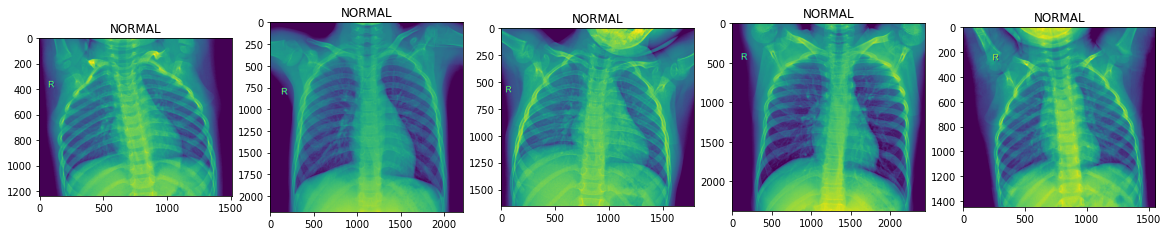

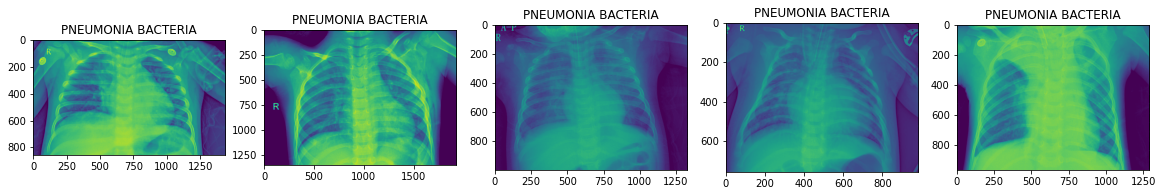

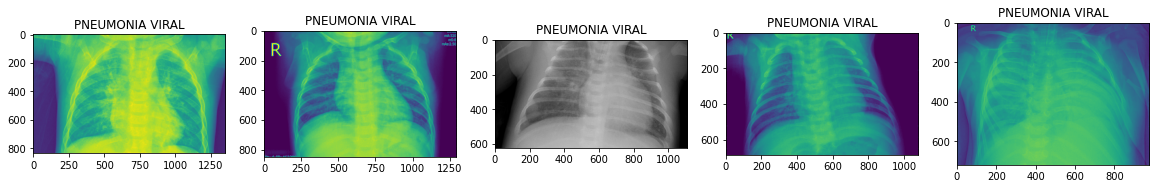

In [8]:
directory = os.listdir(train_path)
for each in directory:
    plt.figure(figsize = (20, 20))
    currentFolder = train_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img = mpimg.imread(fullpath)
        plt.subplot(2, 5, i+1)
        plt.title(each)
        plt.imshow(img)

---

Modelagem

1.   CNN

In [20]:
model = keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [21]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

2.   CNN + Data Augmentation

In [22]:
model_aug = keras.Sequential([
    preprocessing.RandomFlip(mode = 'horizontal'),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [23]:
model_aug.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

3.  CNN Transfer Learning  

In [24]:
pretrained_base = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

pretrained_base.trainable = False

In [25]:
model_transf = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [26]:
model_transf.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

----

Treinamento

In [27]:
tf.get_logger().setLevel('ERROR') #Suprimir warnings to Tensorflow devido ao looping utilizado no Data Augmentation

1. CNN

In [28]:
history = model.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Epoch 1/50
5/5 [==============================] - 41s 2s/step - loss: 10.4198 - accuracy: 0.3486 - val_loss: 1.2642 - val_accuracy: 0.4911
Epoch 2/50
5/5 [==============================] - 27s 2s/step - loss: 1.1576 - accuracy: 0.3960 - val_loss: 1.1289 - val_accuracy: 0.4911
Epoch 3/50
5/5 [==============================] - 26s 2s/step - loss: 1.0535 - accuracy: 0.4838 - val_loss: 0.9763 - val_accuracy: 0.5996
Epoch 4/50
5/5 [==============================] - 25s 2s/step - loss: 0.9409 - accuracy: 0.5828 - val_loss: 0.8592 - val_accuracy: 0.6233
Epoch 5/50
5/5 [==============================] - 26s 2s/step - loss: 0.8537 - accuracy: 0.6635 - val_loss: 0.8024 - val_accuracy: 0.6893
Epoch 6/50
5/5 [==============================] - 26s 2s/step - loss: 0.7917 - accuracy: 0.6586 - val_loss: 0.7402 - val_accuracy: 0.7022
Epoch 7/50
5/5 [==============================] - 26s 2s/step - loss: 0.7309 - accuracy: 0.7023 - val_loss: 0.7040 - val_accuracy: 0.6943
Epoch 8/50
5/5 [=================

2.   CNN + Data Augmentation

In [29]:
history_aug = model_aug.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Epoch 1/50
5/5 [==============================] - 69s 2s/step - loss: 30.7797 - accuracy: 0.3607 - val_loss: 1.5956 - val_accuracy: 0.4911
Epoch 2/50
5/5 [==============================] - 29s 2s/step - loss: 1.3993 - accuracy: 0.4646 - val_loss: 1.2007 - val_accuracy: 0.4911
Epoch 3/50
5/5 [==============================] - 29s 2s/step - loss: 1.0812 - accuracy: 0.4994 - val_loss: 1.0023 - val_accuracy: 0.5957
Epoch 4/50
5/5 [==============================] - 27s 2s/step - loss: 1.0000 - accuracy: 0.5191 - val_loss: 0.9788 - val_accuracy: 0.5089
Epoch 5/50
5/5 [==============================] - 27s 2s/step - loss: 0.9593 - accuracy: 0.5596 - val_loss: 0.9318 - val_accuracy: 0.6371
Epoch 6/50
5/5 [==============================] - 30s 2s/step - loss: 0.9251 - accuracy: 0.5821 - val_loss: 0.9065 - val_accuracy: 0.5523
Epoch 7/50
5/5 [==============================] - 28s 2s/step - loss: 0.9020 - accuracy: 0.5596 - val_loss: 0.8660 - val_accuracy: 0.6568
Epoch 8/50
5/5 [=================

3.   CNN Transfer Learning

In [ ]:
history_transfer = model_transf.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Salvar modelos

In [30]:
model.save('model.h5')
model_aug.save('model_aug.h5')

Acuracidade dos modelos treinados

In [31]:
#Função para plotar os graficos

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

1. CNN

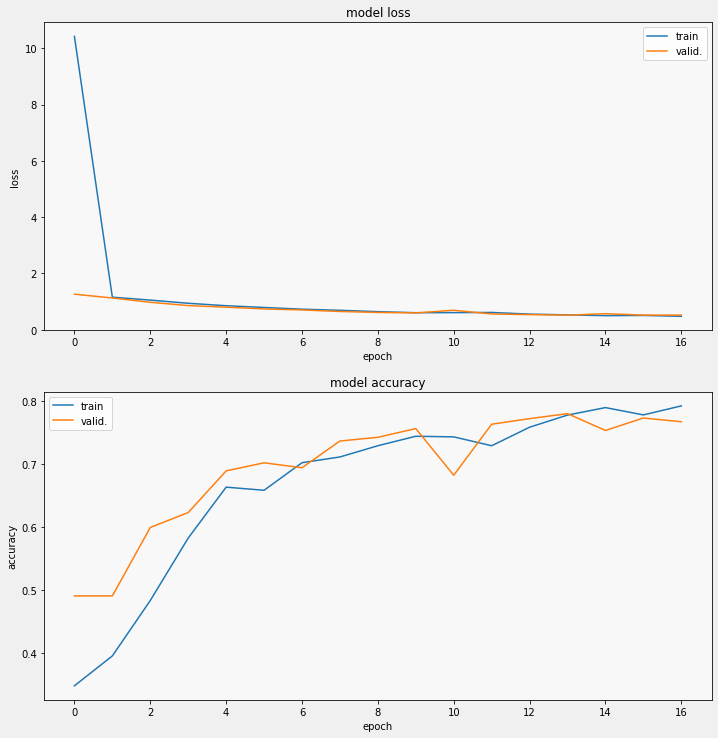

In [32]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy',
    212,
)

2.   CNN + Data Augmentation

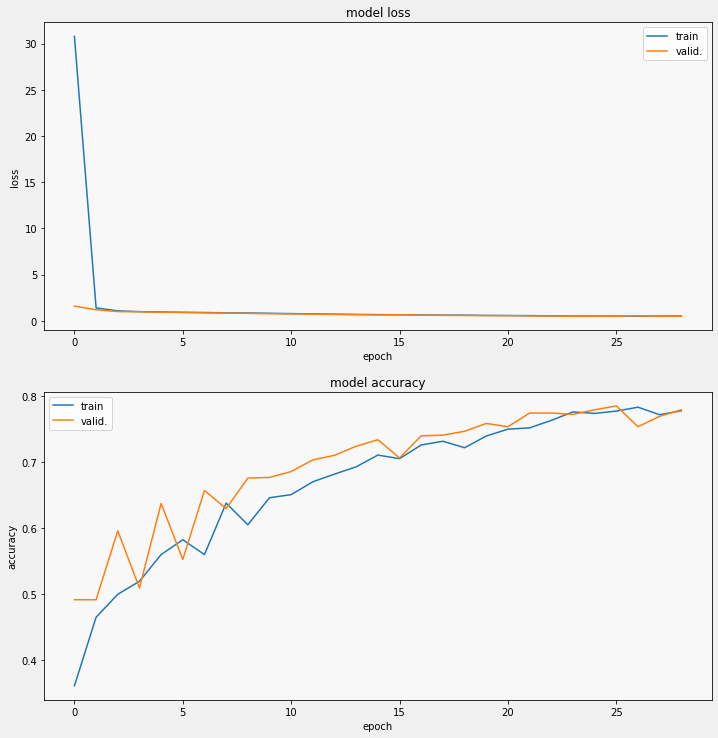

In [33]:
display_training_curves(
    history_aug.history['loss'],
    history_aug.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_aug.history['accuracy'],
    history_aug.history['val_accuracy'],
    'accuracy',
    212,
)

3.   CNN Transfer Learning

In [ ]:
display_training_curves(
    history_transfer.history['loss'],
    history_transfer.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_transfer.history['accuracy'],
    history_transfer.history['val_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
images_ds = ds_test.map(lambda image, label: image)
labels_ds = ds_test.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(1014))).numpy()
rounded_labels = np.argmax(cm_correct_labels, axis=1)
cm_probabilities = model_transf.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

CLASSES = ['NORMAL', 'PNEUMONIA BACTERIA', 'PNEUMONIA VIRAL']

labels = range(len(CLASSES))


2/2 [==============================] - 131s 2s/step


In [ ]:
cmatrix = multilabel_confusion_matrix(rounded_labels, cm_predictions, labels = labels)

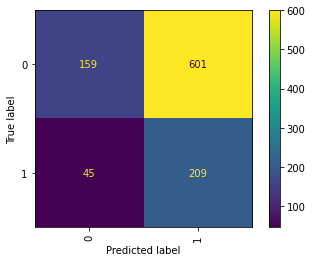

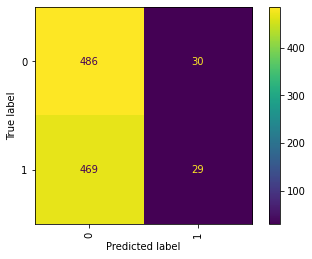

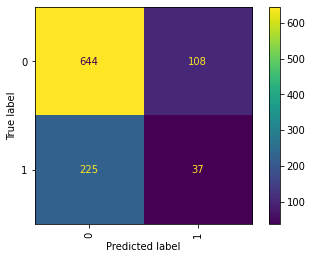

In [ ]:
for confusion_matrix in cmatrix:
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()


In [ ]:
score = f1_score(
    rounded_labels,
    cm_predictions,
    labels=labels,
    average='macro')

precision = precision_score(
    rounded_labels,
    cm_predictions,
    labels=labels,
    average='macro')

recall = recall_score(
    rounded_labels,
    cm_predictions,
    labels=labels,
    average='macro')

In [ ]:
print(score)
print(precision)
print(recall)

0.2635743976809692
0.26067702197330817
0.3470165649876861


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[[0.74 0.75]
  [0.26 0.25]]

 [[0.5  0.61]
  [0.5  0.39]]

 [[0.74 0.73]
  [0.26 0.27]]]


TypeError: ignored

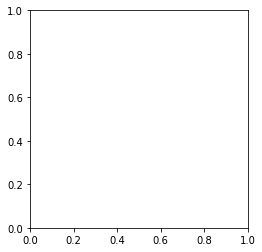

In [ ]:
cmatrix = multilabel_confusion_matrix(rounded_labels, cm_predictions, labels = labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmatrix, classes = ['NORMAL', 'PNEUMONIA BACTERIA', 'PNEUMONIA VIRAL'],
                      title = 'Confusion matrix, without normalization')